In [380]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Telecom Customer Churn:
     Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

#### Content:
     Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

#### The data set includes information about:

   * Customers who left within the last month – the column is called Churn
   * Services that each customer has signed up for – phone, multiple lines, internet, online        * security, online backup, device protection, tech support, and streaming TV and movies
   * Customer account information – how long they’ve been a customer, contract, payment method, 
   * paperless billing, monthly charges, and total charges
   * Demographic info about customers – gender, age range, and if they have partners and dependents
   * Churn - dependent feature ('Yes' denotes customers left, 'No' denotes customer stay here)

In [381]:
# Importing neccessary packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import SelectKBest
from collections import Counter


# ignore warning
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick # for showing percentage in it

In [382]:
data = pd.read_csv('data.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [383]:
# Features types
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

#### **From analysis the dataset, we notice that some of the independent features are in numerical and most of feature are in categorical feature. Seperate into numerical and categorical data for EDA parts**

In [384]:
# Total charges are in object dtype so convert into Numerical feature 
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

#### Separate into Numerical and Categorical feature

In [385]:
# numerical feature
numerical_feature = {feature for feature in data.columns if data[feature].dtypes != 'O'}
print(f'Count of Numerical feature: {len(numerical_feature)}')
print(f'Numerical feature are:\n {numerical_feature}')

Count of Numerical feature: 4
Numerical feature are:
 {'MonthlyCharges', 'TotalCharges', 'tenure', 'SeniorCitizen'}


In [386]:
# Categorical feature
categorical_feature = {feature for feature in data.columns if data[feature].dtypes == 'O'}
print(f'Count of Categorical feature: {len(categorical_feature)}')
print(f'Categorical feature are:\n {categorical_feature}')


Count of Categorical feature: 17
Categorical feature are:
 {'InternetService', 'Partner', 'gender', 'DeviceProtection', 'TechSupport', 'PaperlessBilling', 'OnlineSecurity', 'customerID', 'StreamingMovies', 'Contract', 'Dependents', 'PhoneService', 'StreamingTV', 'PaymentMethod', 'MultipleLines', 'OnlineBackup', 'Churn'}


#### EDA

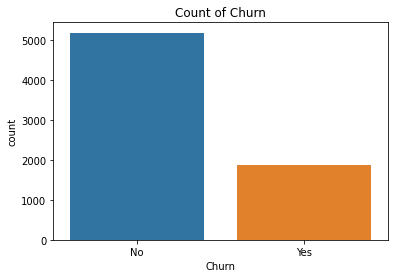

In [387]:
# plotting with target feature
sns.countplot(data=data, x='Churn')
plt.title('Count of Churn')
plt.show()

In [388]:
l1 = data.loc[data['Churn']== 'Yes'].count()[0]
print(f"Pecentage of Left: {l1/len(data['Churn'])}")
print(data.Churn.value_counts())

Pecentage of Left: 0.2653698707936959
No     5174
Yes    1869
Name: Churn, dtype: int64


**1869 of customer are left about 26.5 percentage from overall, this like an imbalance dataset**

In [389]:
### How many amount loss from customer churn
loss = []
for values in data.loc[data['Churn'] == 'Yes', 'TotalCharges']:
    value = float(values)
    loss.append(value)
print(np.round(sum(loss)))

2862927.0


**We have lost arround $2862927 due to customer churn**

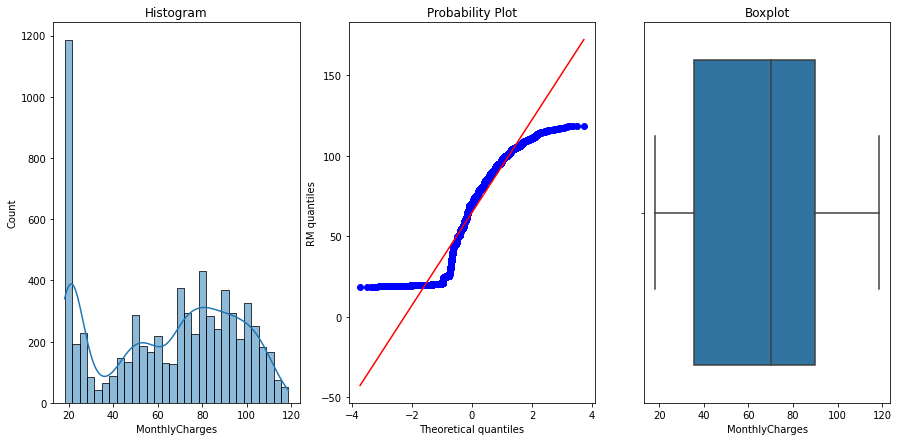

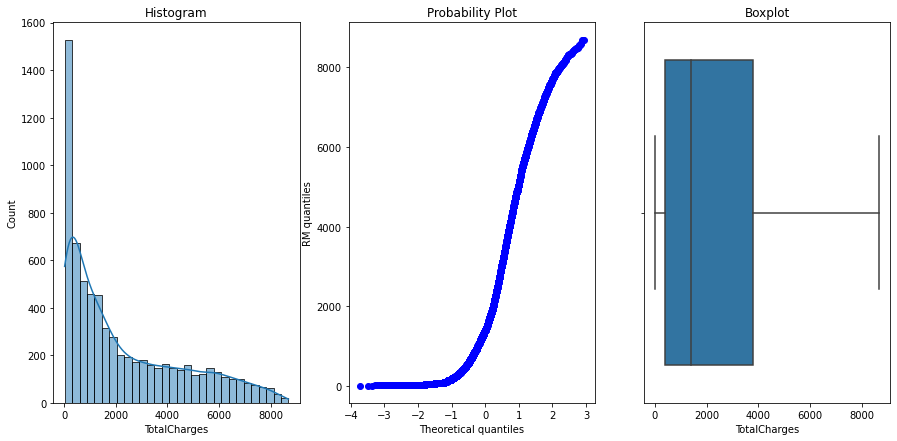

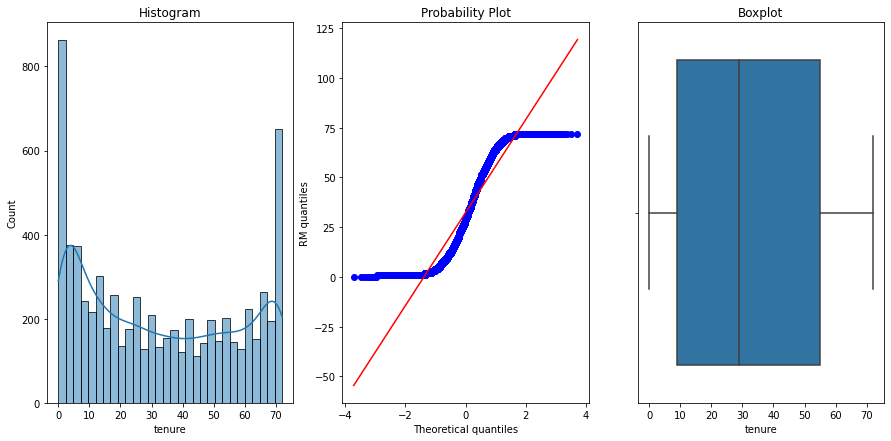

In [390]:
### Plotting numerical feature with probability distribution and checking outlier
for feature in numerical_feature:
    if feature != 'SeniorCitizen':
        plt.figure(figsize=(15,7))
    
        plt.subplot(1, 3, 1)
        sns.histplot(data=data, x=feature, bins=30, kde=True)
        plt.title('Histogram')
    
        plt.subplot(1, 3, 2)
        stats.probplot(data[feature], dist="norm", plot=plt)
        plt.ylabel('RM quantiles')
    
        plt.subplot(1, 3, 3)
        sns.boxplot(x=data[feature])
        plt.title('Boxplot')
    
plt.show()

##### **After ploting histogram probability distribution and box plot to find numerical value are in normally distribution and our dataset has no outlier dataset.So, we don't want to remove the outlier in our dataset**

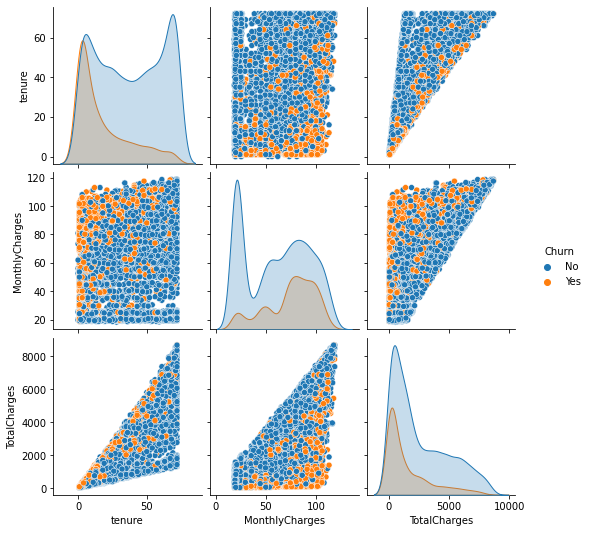

In [391]:
sns.pairplot(data.drop(columns='SeniorCitizen'),hue='Churn', kind='scatter')
plt.show()

Text(0.5, 1.0, '% of Senior Citizens')

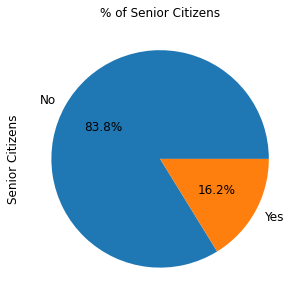

In [392]:
ax = (data['SeniorCitizen'].value_counts()*100.0 /len(data)).plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)

##### **Only 16.2% customers who are senior citizons but remaining 83.8% customers are young people**

#### **Univariate Analysis:**

In [393]:
# for i, feature in enumerate(categorical_feature):
#     if feature != 'TotalCharges':
#         if feature != 'customerID':
#             plt.figure(i)
#             plt.figure(figsize=(12,6))
#             sns.countplot(data=data, x=feature, hue='Churn')
# plt.show()

#### Data Cleaning

In [394]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [395]:
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [396]:
# replace NaN values with mean value
data.TotalCharges = data.TotalCharges.fillna(data.TotalCharges.mean())

<AxesSubplot:>

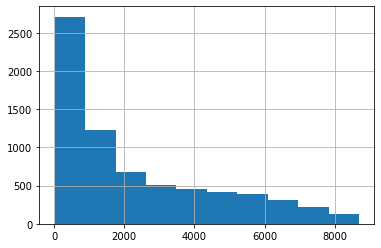

In [397]:
data.TotalCharges.hist()

##### **In this dataset there is no null values, so we dont want to perform Handling missing values. Only perform the Feature Encoding techiniques to convert the categorical feature into numerical feature**

In [398]:
print(categorical_feature)
print(data);

{'InternetService', 'Partner', 'gender', 'DeviceProtection', 'TechSupport', 'PaperlessBilling', 'OnlineSecurity', 'customerID', 'StreamingMovies', 'Contract', 'Dependents', 'PhoneService', 'StreamingTV', 'PaymentMethod', 'MultipleLines', 'OnlineBackup', 'Churn'}
      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male             

In [399]:
encoder = LabelEncoder()
for feature in categorical_feature:
    data[feature] = encoder.fit_transform(data[feature])
print(data);

      customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0           5375       0              0        1           0       1   
1           3962       1              0        0           0      34   
2           2564       1              0        0           0       2   
3           5535       1              0        0           0      45   
4           6511       0              0        0           0       2   
...          ...     ...            ...      ...         ...     ...   
7038        4853       1              0        1           1      24   
7039        1525       0              0        1           1      72   
7040        3367       0              0        1           1      11   
7041        5934       1              1        1           0       4   
7042        2226       1              0        0           0      66   

      PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
0                0              1                0          

In [400]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,3962,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,2564,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,5535,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,6511,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


In [401]:
data.drop(columns=['customerID'], inplace=True)
print(data);

      gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          0              0        1           0       1             0   
1          1              0        0           0      34             1   
2          1              0        0           0       2             1   
3          1              0        0           0      45             0   
4          0              0        0           0       2             1   
...      ...            ...      ...         ...     ...           ...   
7038       1              0        1           1      24             1   
7039       0              0        1           1      72             1   
7040       0              0        1           1      11             0   
7041       1              1        1           0       4             1   
7042       1              0        0           0      66             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0                 1                0     

In [402]:
#Get Correlation of "Churn" with other variables:
# plt.figure(figsize=(15,8))
# data.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

In [403]:
# Finding the correlation between the independent and dependent feature
# plt.figure(figsize=(20, 9))
# sns.heatmap(data.corr(), annot=True)

#### Perform Feature Scaling

In [404]:
# using minmaxscaler methods to scale down the value of features between 0 to 1
scaler = MinMaxScaler()
for feature in numerical_feature:
    data[[feature]] = scaler.fit_transform(data[[feature]])

#### Splitting the dataset into train and test

In [405]:
# splitting dataset into dependent and independent feature
X = data.drop(columns='Churn')
y = data['Churn']

#### Feature Selection:

In [406]:
# selects the feature which has more correlation
selection = SelectKBest()
X = selection.fit_transform(X, y)
print(data);

      gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0          0            0.0        1           0  0.013889             0   
1          1            0.0        0           0  0.472222             1   
2          1            0.0        0           0  0.027778             1   
3          1            0.0        0           0  0.625000             0   
4          0            0.0        0           0  0.027778             1   
...      ...            ...      ...         ...       ...           ...   
7038       1            0.0        1           1  0.333333             1   
7039       0            0.0        1           1  1.000000             1   
7040       0            0.0        1           1  0.152778             0   
7041       1            1.0        1           0  0.055556             1   
7042       1            0.0        0           0  0.916667             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0                

##### **From sklearn using feature selection modules importing the SelectKBest to select the important feature**

In [407]:
# splitting for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [408]:
# its an imbalance dataset
y.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

#### **Apply into machine learning algorithm:**

In [409]:
Log_reg = LogisticRegression(C=150, max_iter=150)
Log_reg.fit(X_train, y_train)
log_pred = Log_reg.predict(X_test)

print(f'Accuracy score : {accuracy_score(log_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(log_pred, y_test)}')
print(f'Classification report :\n {classification_report(log_pred, y_test)}')

Accuracy score : 0.7998580553584103
Confusion matrix :
 [[896 172]
 [110 231]]
Classification report :
               precision    recall  f1-score   support

           0       0.89      0.84      0.86      1068
           1       0.57      0.68      0.62       341

    accuracy                           0.80      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.81      0.80      0.81      1409



In [410]:
# Random forest classifier
Rfc = RandomForestClassifier(n_estimators=120,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=5)
Rfc.fit(X_train, y_train)
rfc_pred = Rfc.predict(X_test)

print(f'Accuracy score : {accuracy_score(rfc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_pred, y_test)}')
print(f'Classification report :\n {classification_report(rfc_pred, y_test)}')

Accuracy score : 0.8069552874378992
Confusion matrix :
 [[919 185]
 [ 87 218]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.83      0.87      1104
           1       0.54      0.71      0.62       305

    accuracy                           0.81      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.83      0.81      0.82      1409



In [411]:
# decisionTree Classifier
Dtc = DecisionTreeClassifier(criterion='gini', splitter='random', min_samples_leaf=15)
Dtc.fit(X_train, y_train)
dtc_pred = Dtc.predict(X_test)

print(f'Accuracy score : {accuracy_score(dtc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_pred, y_test)}')
print(f'Classification report :\n {classification_report(dtc_pred, y_test)}')

Accuracy score : 0.7920511000709723
Confusion matrix :
 [[915 202]
 [ 91 201]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.82      0.86      1117
           1       0.50      0.69      0.58       292

    accuracy                           0.79      1409
   macro avg       0.70      0.75      0.72      1409
weighted avg       0.82      0.79      0.80      1409



In [412]:
# finding the best K value for finding the nearest neighbours
BK_value = []
for x in range(1, 100):
    Knn = KNeighborsClassifier(n_neighbors=x, p=2)
    Knn.fit(X_train, y_train)
    knn_pred = Knn.predict(X_test)
    BK_value.append(np.mean(knn_pred != y_test))

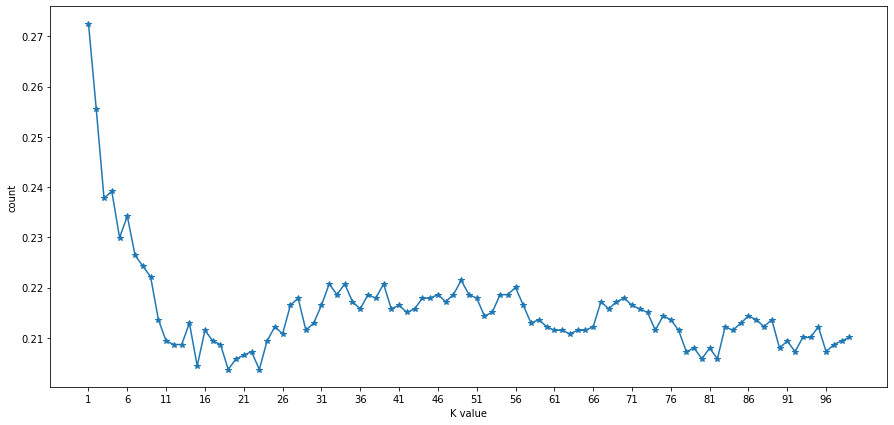

In [413]:
# plot the Kvalue
plt.figure(figsize=(15,7))
plt.xlabel('K value')
plt.ylabel('count')
plt.plot(range(1,100), BK_value, marker='*')
plt.xticks(range(1,100)[::5])
plt.show()

**According to this ploting graph we know that Best k value for KNN Classifier is about 64 using Euclidean_distance to reduce the maximum of TN and FN value**

In [414]:
Knn = KNeighborsClassifier(n_neighbors=64, p=2)
Knn.fit(X_train, y_train)
knn_pred = Knn.predict(X_test)

In [415]:
print(f'Accuracy score : {accuracy_score(knn_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(knn_pred, y_test)}')
print(f'Classification report :\n {classification_report(knn_pred, y_test)}')

Accuracy score : 0.7885024840312278
Confusion matrix :
 [[915 207]
 [ 91 196]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.82      0.86      1122
           1       0.49      0.68      0.57       287

    accuracy                           0.79      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.82      0.79      0.80      1409



**As we compare to the imbalance dataset our model are perform like okay not a better model to build for end to end project. So we need to over smpling data for reducing the TN, FN and increase the FP and TP for model building**

#### **Using SMOTEENN for imbalance dataset:**
     Over-sampling using SMOTE and cleaning using ENN. Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours

In [416]:
st=SMOTEENN()
X_train_st,y_train_st = st.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_st)))

The number of classes before fit Counter({0: 4168, 1: 1466})
The number of classes after fit Counter({0: 2470, 1: 2409})


In [417]:
# splitting the over sampling dataset 
X_train_sap, X_test_sap, y_train_sap, y_test_sap = train_test_split(X_train_st, y_train_st, test_size=0.2)

In [418]:
# decisionTree Classifier
Dtc_sampling = DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=7, min_samples_leaf=15)
Dtc_sampling.fit(X_train_sap, y_train_sap)
dtc_sampling_pred = Dtc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(dtc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(dtc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9334016393442623
Confusion matrix :
 [[447  29]
 [ 36 464]]
Classification report :
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       476
           1       0.94      0.93      0.93       500

    accuracy                           0.93       976
   macro avg       0.93      0.93      0.93       976
weighted avg       0.93      0.93      0.93       976



In [419]:
# Random forest classifier
Rfc_sampling = RandomForestClassifier(n_estimators=150,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=6)
Rfc_sampling.fit(X_train_sap, y_train_sap)
rfc_sampling_pred = Rfc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(rfc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(rfc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9456967213114754
Confusion matrix :
 [[454  24]
 [ 29 469]]
Classification report :
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       478
           1       0.95      0.94      0.95       498

    accuracy                           0.95       976
   macro avg       0.95      0.95      0.95       976
weighted avg       0.95      0.95      0.95       976



In [420]:
# logistic regression
Log_reg_sampling = LogisticRegression(C=10, max_iter=150)
Log_reg_sampling.fit(X_train_sap, y_train_sap)
Log_sampling_pred = Log_reg_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(Log_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(Log_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(Log_sampling_pred, y_test_sap)}')

Accuracy score : 0.9170081967213115
Confusion matrix :
 [[434  32]
 [ 49 461]]
Classification report :
               precision    recall  f1-score   support

           0       0.90      0.93      0.91       466
           1       0.94      0.90      0.92       510

    accuracy                           0.92       976
   macro avg       0.92      0.92      0.92       976
weighted avg       0.92      0.92      0.92       976



In [421]:
# KNN classifier algorithm
Knn_sampling = KNeighborsClassifier(n_neighbors=3, p=2)  # using Euclidean_distance
Knn_sampling.fit(X_train_sap, y_train_sap)
knn_sampling_pred = Knn_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(knn_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(knn_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(knn_sampling_pred, y_test_sap)}')

Accuracy score : 0.9610655737704918
Confusion matrix :
 [[461  16]
 [ 22 477]]
Classification report :
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       477
           1       0.97      0.96      0.96       499

    accuracy                           0.96       976
   macro avg       0.96      0.96      0.96       976
weighted avg       0.96      0.96      0.96       976



**After Oversampling the dataset our model performs is pretty good. From our 4 model KNN classifier performs better than all.**